# Dogs vs. cats (PyTorch)

In this activity, the goal is to distinguish the animals pictured in these images between cats and dogs.

The 2,000 images used in this kata are excerpted from the [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/) dataset available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

![Woof Meow](woof_meow.jpg)

## Environment setup

In [4]:
# The Python Imaging Library is needed to display images 
!pip install pillow
!pip install torch 

You should consider upgrading via the '/home/onajib/miniconda3/bin/python3 -m pip install --upgrade pip' command.
  Using cached torch-1.13.0-cp39-cp39-manylinux1_x86_64.whl (890.2 MB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
You should consider upgrading via the '/home/onajib/miniconda3/bin/python3 -m pip install --upgrade pip' command.


In [8]:
!pip install torchvision
!python3 -m pip install --upgrade pip


You should consider upgrading via the '/home/onajib/miniconda3/bin/python3 -m pip install --upgrade pip' command.
  Using cached pip-22.3.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4


In [17]:
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 11.3 MB/s eta 0:00:0000:0100:01
  Using cached pytz-2022.6-py2.py3-none-any.whl (498 kB)


In [9]:
# Import base packages
import os
import zipfile
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [10]:
# Import ML packages (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')

import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard

PyTorch version: 1.13.0+cu117


## Utilify functions

In [11]:
def plot_decision_boundary(pred_func, X, y, figure=None):
    """Plot a decision boundary"""

    if figure is None:  # If no figure is given, create a new one
        plt.figure()
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)

## Step 1: Loading the data

In [12]:
# Downloading our example data, a .zip of 2,000 JPG pictures, and extracting it locally in `/tmp`
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-11-29 20:09:45--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.203.240, 216.58.205.208, 142.251.37.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.203.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65,43M  10,8MB/s    in 6,0s    

2022-11-29 20:09:51 (10,9 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [13]:
# Extracting zip file to the base directory `/tmp/cats_and_dogs_filtered`
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Step 2: Exploring the data

In [14]:
print(f'Training cat images: {len(os.listdir(train_cats_dir))}')
print(f'Training dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Validation cat images: {len(os.listdir(validation_cats_dir))}')
print(f'Validation dog images: {len(os.listdir(validation_dogs_dir))}')

# Display some images files for cats and dogs
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])
train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

Training cat images: 1000
Training dog images: 1000
Validation cat images: 500
Validation dog images: 500
['cat.866.jpg', 'cat.903.jpg', 'cat.387.jpg', 'cat.588.jpg', 'cat.69.jpg', 'cat.994.jpg', 'cat.938.jpg', 'cat.450.jpg', 'cat.235.jpg', 'cat.15.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


/tmp/cats_and_dogs_filtered/train/cats
(375, 499, 3)


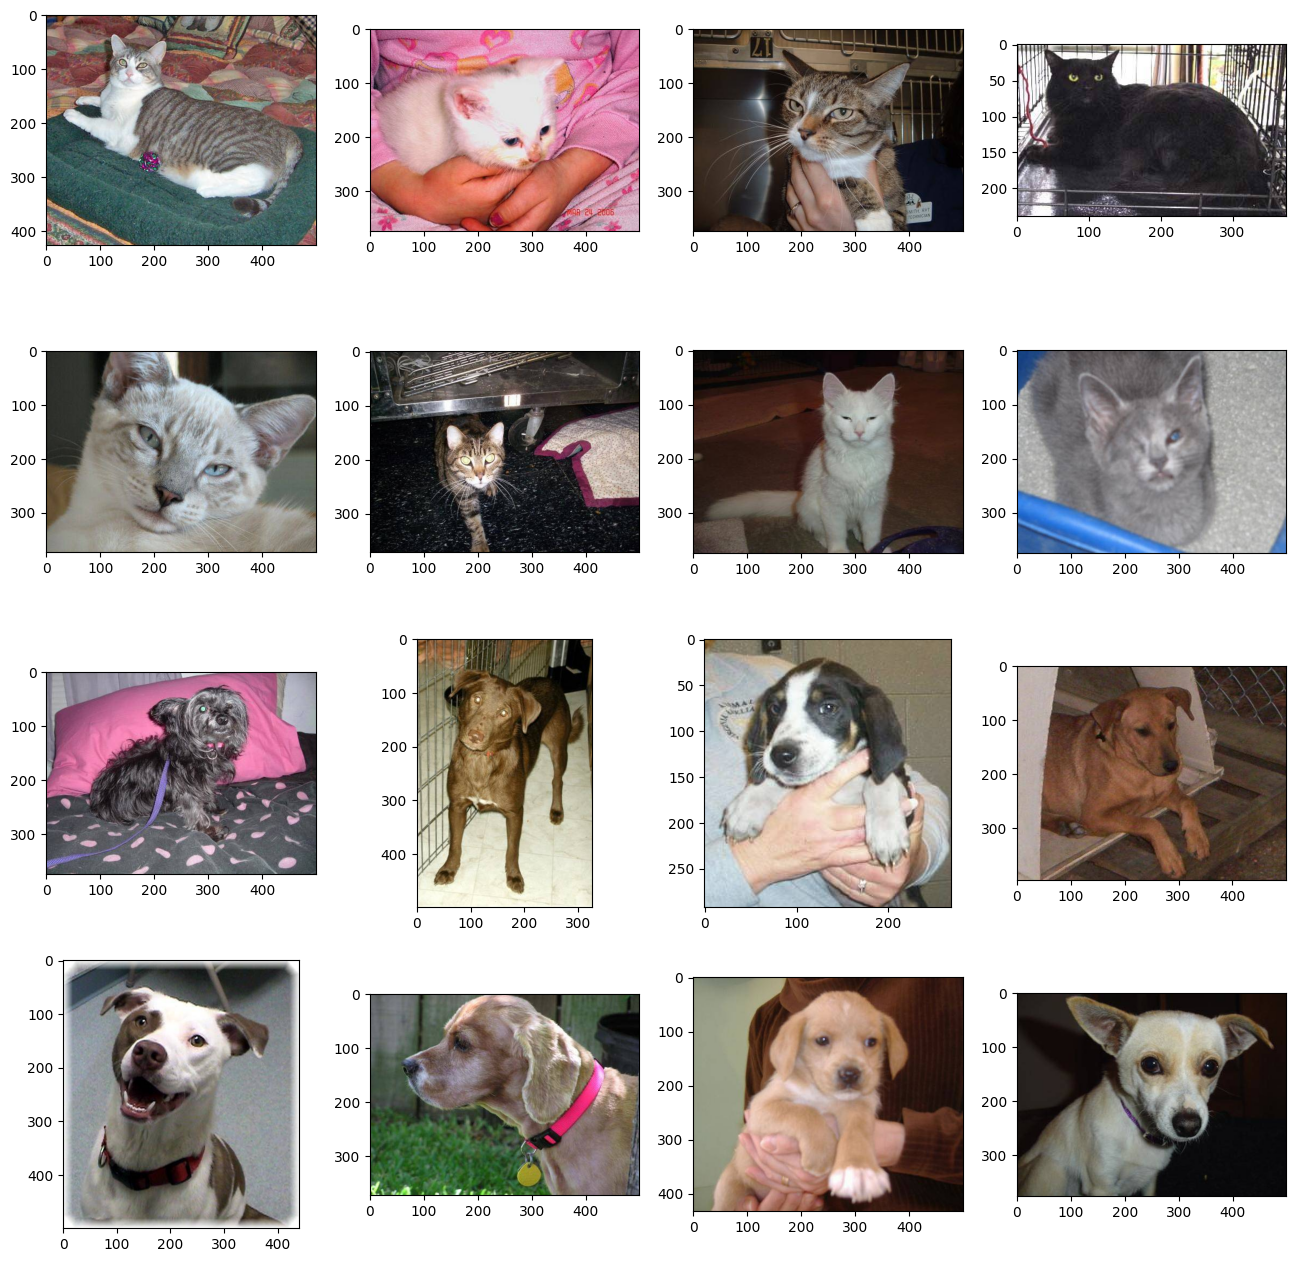

In [15]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
print(train_cats_dir)

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    img = mpimg.imread(img_path)
    plt.imshow(img)


print(img.shape)

## Step 3: Preparing the data

### Question

Prepare the data by resizing all images to 150x150 and normalizing them.

Create a `DataLoader` for training data and another one for validation data.

In [90]:
# YOUR CODE HERE

import torch
torch.cuda.is_available()

import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import InterpolationMode

class CatsDogsImageDataset(Dataset):
    def __init__(self, train_cats_dir,train_dogs_dir, transform, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.cats_dir = train_cats_dir
        self.dogs_dir = train_dogs_dir

        self.labels = []
        self.cats_fnames = os.listdir(self.cats_dir)
        self.dogs_fnames = os.listdir(self.dogs_dir)
        for fname in self.cats_fnames: 
            img_path = os.path.join(self.cats_dir, fname) 
            self.labels.append(0)
        for fname in self.dogs_fnames: 
            img_path = os.path.join(self.dogs_dir, fname) 
            self.labels.append(1)
        self.fnames = self.cats_fnames + self.dogs_fnames 
        self.transform = transform


    def __len__(self):
        return len(self.cats_fnames) + len(self.dogs_fnames)


    def __getitem__(self, idx):
        if(self.labels[idx] == 0): # in cats
            fname = self.fnames[idx]
            img_path = os.path.join(self.cats_dir, fname) 
            image =  mpimg.imread(img_path)
        if(self.labels[idx] == 1):
            fname = self.fnames[idx]
            img_path = os.path.join(self.dogs_dir, fname) 
            image = read_image(img_path)
        label = self.labels[idx ]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, torch.tensor(label)

transformation = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    torchvision.transforms.Resize([150,150])
])

train_data = CatsDogsImageDataset(train_cats_dir, train_dogs_dir, transform=transformation)

test_data = CatsDogsImageDataset(validation_cats_dir, validation_dogs_dir, transform=transformation)


trainloader = torch.utils.data.DataLoader(train_data, batch_size=32,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_data, batch_size=32,
                                          shuffle=True, num_workers=2)


## Step 4: Training a model

### Question

Create a CNN model able to be trained on 150x150x3 images. Instantiate it into the `net` variable.

In [91]:
# YOUR CODE HERE
# code imported from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch.nn as nn
import torch.nn.functional as F

# Define a convolutional neural network

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(150*150*3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# Define a Loss function and optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the network

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


TypeError: forward() missing 1 required positional argument: 'x'

## Step 5: Evaluating the model

### Question

Compute accuracy on validation data. Store it into the `val_acc` variable.

Validation accuracy should be > 70%.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print(f'Validation accuracy: {val_acc * 100}%')

# Assert final accuracy
assert val_acc > 0.70